# **Chargement des librairies**

In [1]:
# ==================== Standard Libraries ====================
import os
import json
from datetime import datetime
from collections import Counter

# ==================== Data Manipulation ====================
import pandas as pd
import numpy as np

# ==================== Visualization ====================
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== Image Processing ====================
from PIL import Image, ImageEnhance

# ==================== Progress Monitoring ====================
from tqdm import tqdm

# ==================== PyTorch & Torchvision ====================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

# ==================== Evaluation Metrics ====================
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ==================== Imbalanced Data Handling ====================
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# **Preparation avant Modelisation**

In [ ]:
# Définition des chemins
train_image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\train"
val_image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\val"
test_image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\test"

train_file = "./Preprocessing/dfs/train.csv"
val_file = "./Preprocessing/dfs/val.csv"
test_file = "./Preprocessing/dfs/test.csv"

# Création du dossier de sauvegarde
model_save_path = "./RESNET50"
os.makedirs(model_save_path, exist_ok=True)

# Chargement des fichiers CSV 
df_train = pd.read_csv(train_file)
df_val = pd.read_csv(val_file)
df_test = pd.read_csv(test_file)

# Création des chemins d’images pour chaque ligne
df_train["image_path"] = df_train.apply(lambda row: os.path.join(train_image_folder, f"image_{row['imageid']}_product_{row['productid']}.jpg"), axis=1)
df_val["image_path"] = df_val.apply(lambda row: os.path.join(val_image_folder, f"image_{row['imageid']}_product_{row['productid']}.jpg"), axis=1)
df_test["image_path"] = df_test.apply(lambda row: os.path.join(test_image_folder, f"image_{row['imageid']}_product_{row['productid']}.jpg"), axis=1)

# Extraction du nom de fichier image
df_train["image_name"] = df_train["image_path"].apply(lambda x: os.path.basename(x))
df_val["image_name"] = df_val["image_path"].apply(lambda x: os.path.basename(x))
df_test["image_name"] = df_test["image_path"].apply(lambda x: os.path.basename(x))

# Création d’un mapping des labels
unique_labels = sorted(set(df_train["prdtypecode"].unique()).union(set(df_val["prdtypecode"].unique())).union(set(df_test["prdtypecode"].unique())))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Remapping des labels pour chaque image
train_labels_dict = {img: label_map[label] for img, label in zip(df_train["image_name"], df_train["prdtypecode"])}
val_labels_dict = {img: label_map[label] for img, label in zip(df_val["image_name"], df_val["prdtypecode"])}
test_labels_dict = {img: label_map[label] for img, label in zip(df_test["image_name"], df_test["prdtypecode"])}

In [3]:
labelcat = {
    10: "Livre occasion",
    40: "Jeu vidéo, accessoire tech.",
    50: "Accessoire Console",
    60: "Console de jeu",
    1140: "Figurine",
    1160: "Carte Collection",
    1180: "Jeu Plateau",
    1280: "Jouet enfant, déguisement",
    1281: "Jeu de société",
    1300: "Jouet tech",
    1301: "Paire de chaussettes",
    1302: "Jeu extérieur, vêtement",
    1320: "Autour du bébé",
    1560: "Mobilier intérieur",
    1920: "Chambre",
    1940: "Cuisine",
    2060: "Décoration intérieure",
    2220: "Animal",
    2280: "Revues et journaux",
    2403: "Magazines, livres et BDs",
    2462: "Jeu occasion",
    2522: "Bureautique et papeterie",
    2582: "Mobilier extérieur",
    2583: "Autour de la piscine",
    2585: "Bricolage",
    2705: "Livre neuf",
    2905: "Jeu PC",
}

index_to_catid = {i: cat_id for i, cat_id in enumerate(labelcat.keys())}
catid_to_label = labelcat


# **Modelisation Resnet50**

## Modele 1

### Configuration

In [4]:
# Définition des chemins & création du dossier
dataset_path = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images"

# Détection du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Génération d'un timestamp unique pour chaque entraînement
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Noms des fichiers de sauvegarde
model= "model1"
loss_log_path = os.path.join(model_save_path, f"training_loss_{model}_{timestamp}.txt")
model_save_file = os.path.join(model_save_path, f"resnet50_{model}_{timestamp}.pth")
config_save_file = os.path.join(model_save_path, f"config_{model}_{timestamp}.json")

# Prétraitement des images
def preprocess_image(image):
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(2.5)  # Netteté
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.2)  # Luminosité
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(1.2)  # Saturation

    img_array = np.array(image).astype(np.float32) # Conversion en float pour opérations mathématiques
    img_array[:, :, 0] *= 0.9   # Réduction du rouge
    img_array[:, :, 1] *= 1.05  # Augmentation du vert
    img_array[:, :, 2] *= 1.05  # Augmentation du bleu
    img_array = np.clip(img_array, 0, 255)

    return Image.fromarray(img_array.astype(np.uint8))

# Transformation des images pour ResNet50 
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Définition du Dataset 
class ProductImageDataset(Dataset):
    def __init__(self, labels_dict, image_folder, transform=None, use_custom_preprocess=False):
        self.labels_dict = labels_dict
        self.image_folder = image_folder
        self.image_files = list(labels_dict.keys())
        self.transform = transform
        self.use_custom_preprocess = use_custom_preprocess 
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f" Image non trouvée : {img_path}")
            return torch.zeros((3, 224, 224)), -1

        if self.use_custom_preprocess:
            image = preprocess_image(image)
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels_dict[img_name], dtype=torch.long)

        return image, label

# Chargement & configuration du modèle
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 27)  # Adaptation à 27 classes
model = model.to(device)

# Configuration du modèle
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 8

# Fonction d'entraînement
def train_model(model, train_loader, val_loader, epochs=num_epochs):
    best_loss = float('inf')
    
    with open(loss_log_path, "w") as f_log:
        f_log.write("Epoch,Train Loss,Val Loss\n")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        #  Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        #  Sauvegarde des logs de perte
        with open(loss_log_path, "a") as f_log:
            f_log.write(f"{epoch+1},{avg_train_loss:.4f},{avg_val_loss:.4f}\n")

        #  Sauvegarde du meilleur modèle
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_file)

    print(f" Entraînement terminé ! Meilleur modèle sauvegardé avec une perte de validation de {best_loss:.4f}")
    print(f" Modèle sauvegardé : {model_save_file}")
    print(f" Log des pertes : {loss_log_path}")



# Sauvegarde des hyperparamètres
config = {
    "model": "ResNet50",
    "num_classes": 27,
    "optimizer": "Adam",
    "learning_rate": 3e-4,
    "batch_size": 32,
    "num_epochs": num_epochs
}

with open(config_save_file, "w") as f:
    json.dump(config, f, indent=4)

print(f" Config sauvegardée : {config_save_file}")

 Config sauvegardée : ./RESNET50\config_model1_20250326_182848.json


### Entrainement

In [5]:
#  Création des Datasets
train_dataset = ProductImageDataset(labels_dict=train_labels_dict, image_folder=train_image_folder, transform=transform)
val_dataset = ProductImageDataset(labels_dict=val_labels_dict, image_folder=val_image_folder, transform=transform)
test_dataset = ProductImageDataset(labels_dict=test_labels_dict, image_folder=test_image_folder, transform=transform)


#  Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#  Lancement de l'entraînement
train_model(model, train_loader, val_loader, num_epochs)

Epoch 1/8 - Validation: 100%|██████████| 266/266 [01:12<00:00,  3.65it/s]


Epoch 1/8 - Train Loss: 1.7349 | Val Loss: 1.5328


Epoch 2/8 - Validation: 100%|██████████| 266/266 [01:11<00:00,  3.71it/s]


Epoch 2/8 - Train Loss: 1.4162 | Val Loss: 1.4605


Epoch 3/8 - Validation: 100%|██████████| 266/266 [01:10<00:00,  3.77it/s]


Epoch 3/8 - Train Loss: 1.2339 | Val Loss: 1.3818


Epoch 4/8 - Validation: 100%|██████████| 266/266 [01:13<00:00,  3.63it/s]


Epoch 4/8 - Train Loss: 1.0714 | Val Loss: 1.3204


Epoch 5/8 - Validation: 100%|██████████| 266/266 [01:12<00:00,  3.69it/s]


Epoch 5/8 - Train Loss: 0.8942 | Val Loss: 1.3833


Epoch 6/8 - Validation: 100%|██████████| 266/266 [01:10<00:00,  3.75it/s]


Epoch 6/8 - Train Loss: 0.7238 | Val Loss: 1.4198


Epoch 7/8 - Validation: 100%|██████████| 266/266 [01:05<00:00,  4.08it/s]


Epoch 7/8 - Train Loss: 0.5677 | Val Loss: 1.5877


Epoch 8/8 - Validation: 100%|██████████| 266/266 [01:09<00:00,  3.85it/s]

Epoch 8/8 - Train Loss: 0.4564 | Val Loss: 1.6653
 Entraînement terminé ! Meilleur modèle sauvegardé avec une perte de validation de 1.3204
 Modèle sauvegardé : ./RESNET50\resnet50_model1_20250326_182848.pth
 Log des pertes : ./RESNET50\training_loss_model1_20250326_182848.txt


### Visualisation de l'evolution des pertes

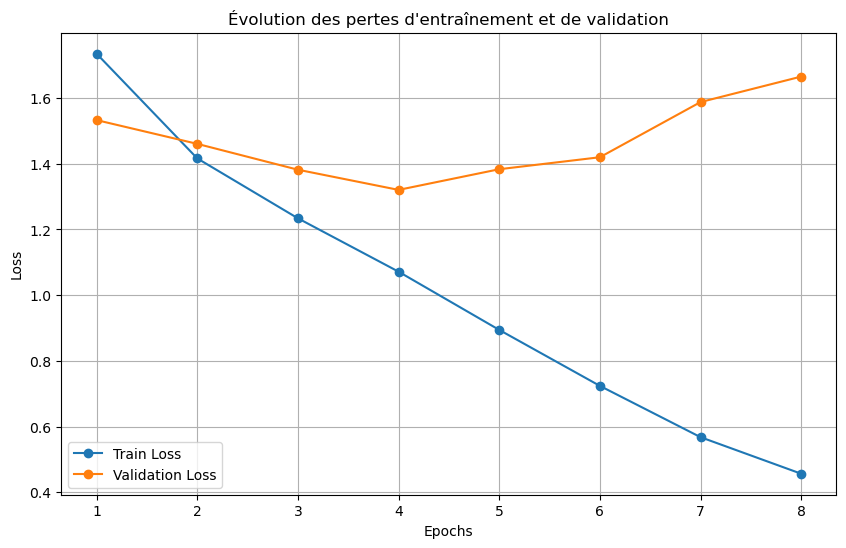

In [14]:
#  Chargement des pertes
df_loss_1 = pd.read_csv("./RESNET50/training_loss_model1_20250326_182848.txt")
    
#  Tracer l'évolution des pertes
plt.figure(figsize=(10, 6))
plt.plot(df_loss_1["Epoch"], df_loss_1["Train Loss"], label="Train Loss", marker="o")
plt.plot(df_loss_1["Epoch"], df_loss_1["Val Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution des pertes d'entraînement et de validation")
plt.legend()
plt.grid(True)
plt.show()


### Evaluation

Évaluation sur Train: 100%|██████████| 2123/2123 [09:31<00:00,  3.72it/s]



 Classification Report (Train):
                             precision    recall  f1-score   support

         Accessoire Console       0.74      0.45      0.56      1345
                     Animal       0.87      0.36      0.51       659
       Autour de la piscine       0.83      0.95      0.89      8167
             Autour du bébé       0.72      0.59      0.65      2593
                  Bricolage       0.70      0.49      0.58      1997
   Bureautique et papeterie       0.79      0.82      0.80      3991
           Carte Collection       0.97      0.96      0.97      3162
                    Chambre       0.86      0.86      0.86      3442
             Console de jeu       0.85      0.82      0.83       666
                    Cuisine       0.90      0.82      0.86       642
      Décoration intérieure       0.53      0.73      0.62      3994
                   Figurine       0.67      0.86      0.75      2137
                     Jeu PC       0.99      0.96      0.97       698


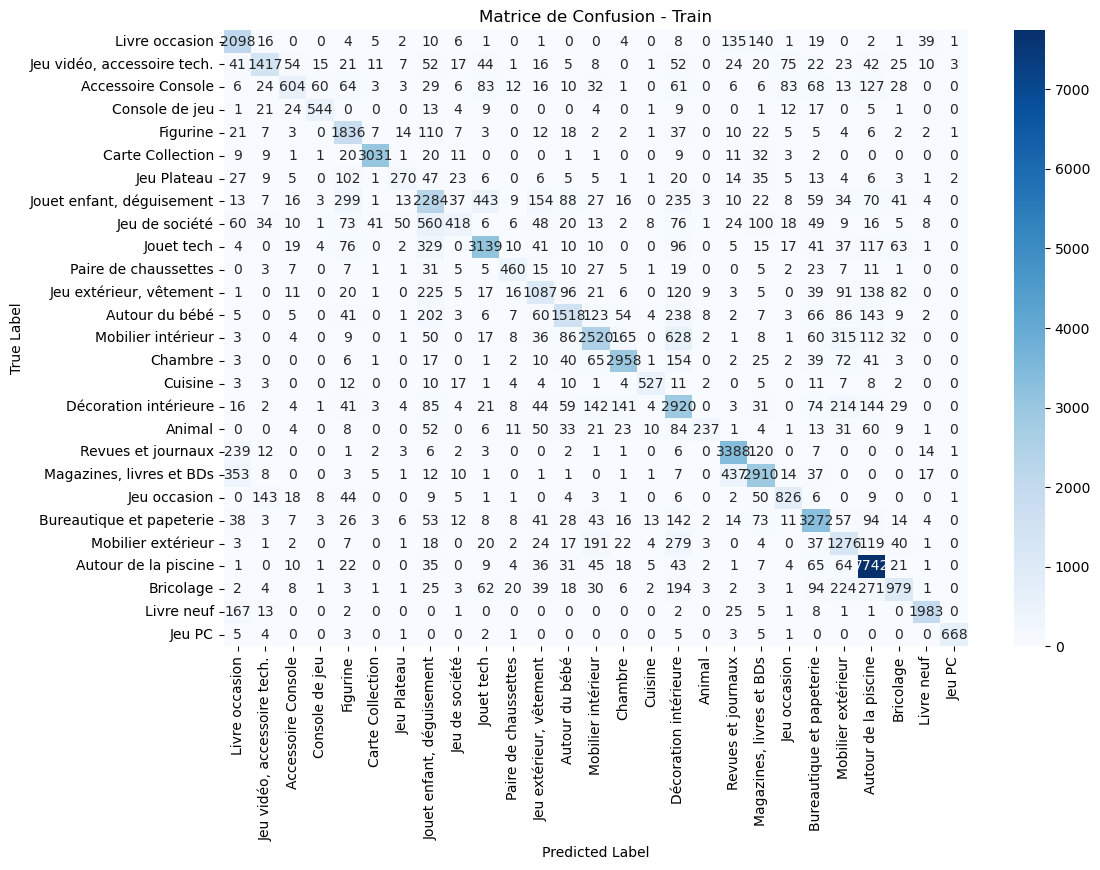

Évaluation sur Validation: 100%|██████████| 266/266 [01:11<00:00,  3.73it/s]



 Classification Report (Validation):
                             precision    recall  f1-score   support

         Accessoire Console       0.42      0.18      0.26       168
                     Animal       0.25      0.07      0.11        82
       Autour de la piscine       0.75      0.85      0.80      1021
             Autour du bébé       0.46      0.39      0.42       324
                  Bricolage       0.49      0.30      0.37       250
   Bureautique et papeterie       0.64      0.70      0.67       499
           Carte Collection       0.91      0.88      0.90       396
                    Chambre       0.78      0.76      0.77       431
             Console de jeu       0.72      0.63      0.67        83
                    Cuisine       0.68      0.53      0.60        81
      Décoration intérieure       0.41      0.58      0.48       499
                   Figurine       0.49      0.67      0.57       267
                     Jeu PC       0.94      0.92      0.93      

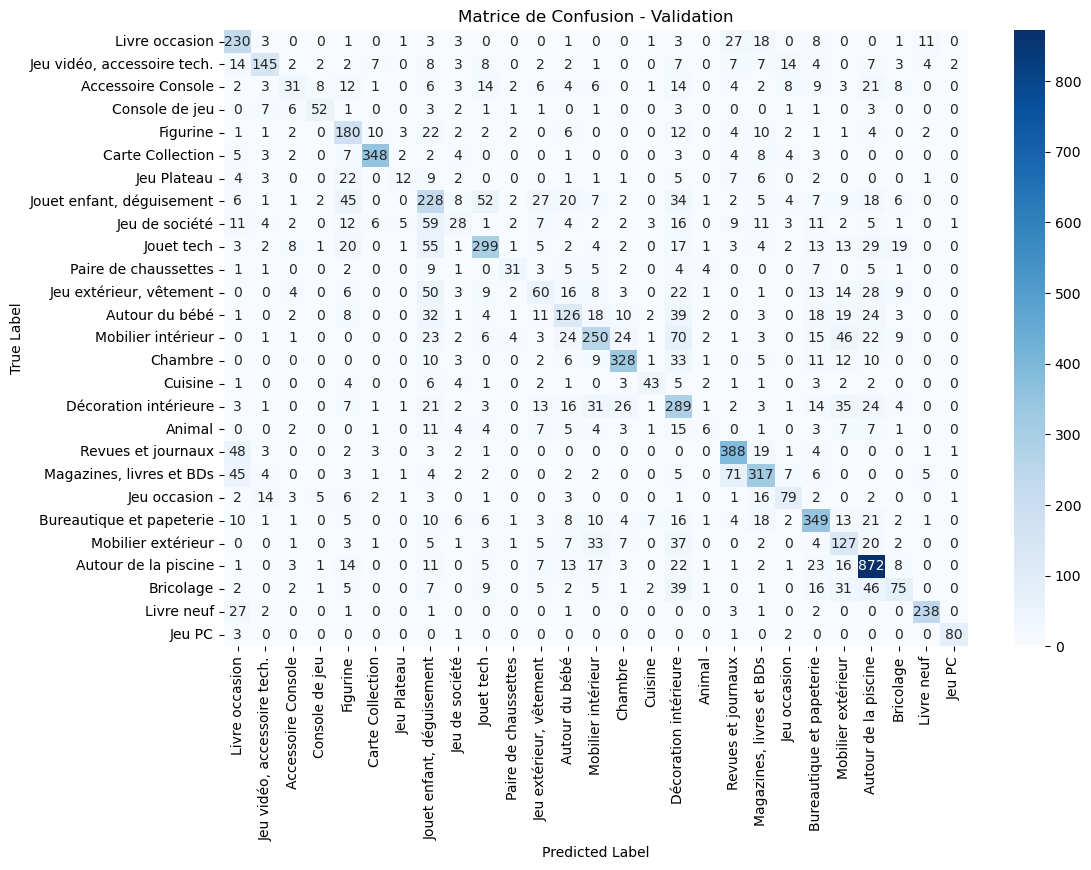

Évaluation sur Test: 100%|██████████| 266/266 [01:14<00:00,  3.56it/s]



 Classification Report (Test):
                             precision    recall  f1-score   support

         Accessoire Console       0.42      0.18      0.25       168
                     Animal       0.59      0.16      0.25        83
       Autour de la piscine       0.74      0.86      0.79      1021
             Autour du bébé       0.49      0.38      0.43       324
                  Bricolage       0.47      0.25      0.33       249
   Bureautique et papeterie       0.66      0.71      0.68       499
           Carte Collection       0.94      0.91      0.93       395
                    Chambre       0.77      0.77      0.77       430
             Console de jeu       0.58      0.61      0.60        83
                    Cuisine       0.73      0.60      0.66        80
      Décoration intérieure       0.42      0.62      0.50       500
                   Figurine       0.53      0.68      0.59       267
                     Jeu PC       0.95      0.91      0.93        87
 

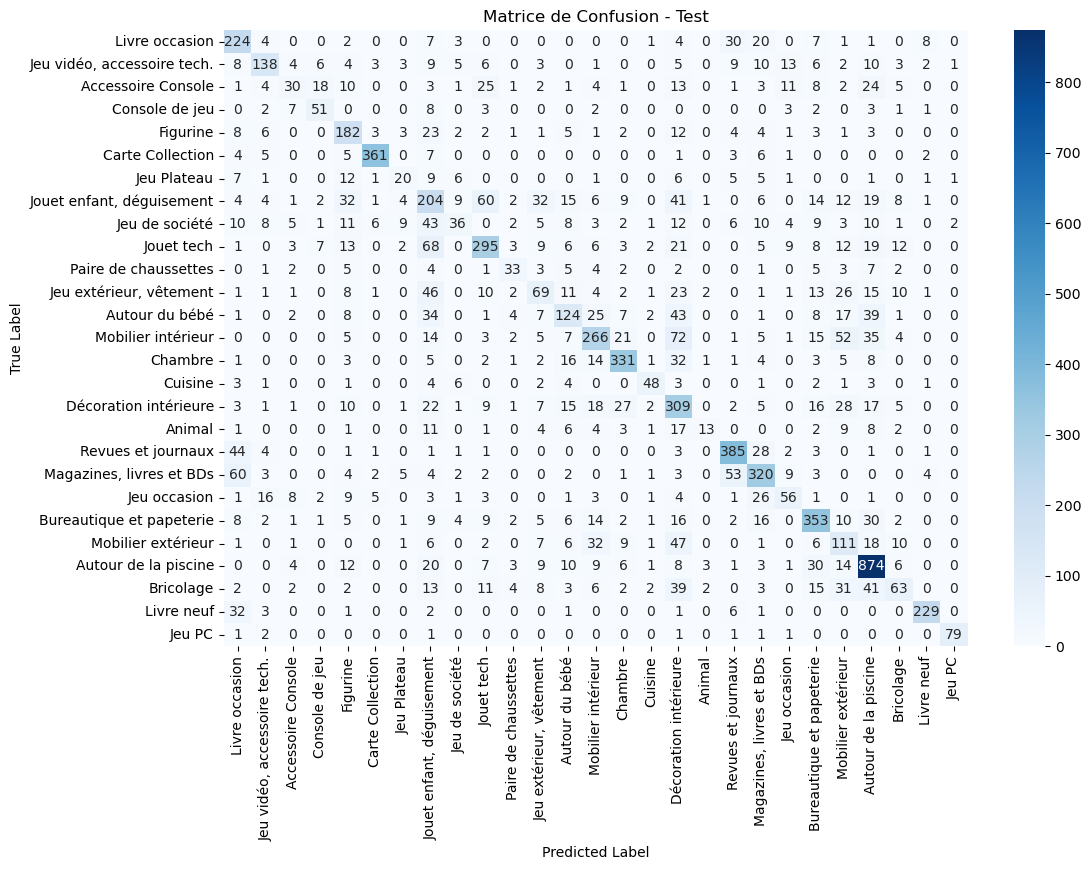

In [17]:
# Chargement du modèle entraîné
model_path = "./RESNET50/resnet50_model1_20250326_182848.pth" 
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Définition de la fonction d'évaluation
def evaluate_model(dataloader, dataset_name):
    y_true = []
    y_pred = []

    # Évaluation du modèle
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Évaluation sur {dataset_name}"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Conversion des index en noms de catégories
    true_labels = [catid_to_label[index_to_catid[label]] for label in y_true]
    pred_labels = [catid_to_label[index_to_catid[pred]] for pred in y_pred]

    # Rapport de classification
    print(f"\n Classification Report ({dataset_name}):")
    report = classification_report(true_labels, pred_labels)
    print(report)

    # Calcul du F1-score weighted
    f1_weighted = f1_score(true_labels, pred_labels, average="weighted")
    print(f" F1-score weighted ({dataset_name}): {f1_weighted:.4f}")

    # Matrice de confusion
    labels_order = list(catid_to_label.values())
    conf_matrix = confusion_matrix(true_labels, pred_labels, labels=labels_order)

    # Affichage de la heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Matrice de Confusion - {dataset_name}")
    plt.show()

# Évaluation sur train, validation et test
evaluate_model(train_loader, "Train")
evaluate_model(val_loader, "Validation")
evaluate_model(test_loader, "Test")

## Modele 2bis: Data augmentation - preprocessing image applied

### Configuration

In [15]:
modele= "model2b"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
loss_log_path = os.path.join(model_save_path, f"training_loss_{modele}_{timestamp}.txt")
model_save_file = os.path.join(model_save_path, f"resnet50_{modele}_{timestamp}.pth")
config_save_file = os.path.join(model_save_path, f"config_{modele}_{timestamp}.json")

# Transformation des images avec Data Augmentation ----
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Sauvegarde des hyperparamètres 
config = {
    "model": "ResNet50",
    "num_classes": 27,
    "optimizer": "Adam",
    "learning_rate": 3e-4,
    "batch_size": 32,
    "num_epochs": num_epochs,
    "transformations": {
        "resize": (256, 256),
        "center_crop": 224,
        "normalize_mean": [0.485, 0.456, 0.406],
        "normalize_std": [0.229, 0.224, 0.225],
        "sharpening": 2.5,
        "brightness": 1.2,
        "saturation": 1.2,
        "red_correction": 0.9,
        "green_correction": 1.05,
        "blue_correction": 1.05},
        "transformations": train_transform.__repr__()  # Enregistrer la config des augmentations
}

with open(config_save_file, "w") as f:
    json.dump(config, f, indent=4)

print(f" Config sauvegardée : {config_save_file}")

 Config sauvegardée : ./RESNET50\config_model2b_20250327_014445.json


### Entrainement

In [16]:
#  Création des Datasets
train_dataset_2b = ProductImageDataset(labels_dict=train_labels_dict, image_folder=train_image_folder, transform=train_transform, use_custom_preprocess=True)
val_dataset_2b = ProductImageDataset(labels_dict=val_labels_dict, image_folder=val_image_folder, transform=transform, use_custom_preprocess=True)
test_dataset_2b = ProductImageDataset(labels_dict=test_labels_dict, image_folder=test_image_folder, transform=transform, use_custom_preprocess=True)

#  Création des DataLoaders
train_loader_2b = DataLoader(train_dataset_2b, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader_2b = DataLoader(val_dataset_2b, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader_2b = DataLoader(test_dataset_2b, batch_size=32, shuffle=False)


#  Lancement de l'entraînement
train_model(model, train_loader_2b, val_loader_2b, num_epochs)

Epoch 1/8 - Validation: 100%|██████████| 266/266 [02:31<00:00,  1.76it/s]


Epoch 1/8 - Train Loss: 1.5162 | Val Loss: 1.4281


Epoch 2/8 - Validation: 100%|██████████| 266/266 [02:51<00:00,  1.55it/s]


Epoch 2/8 - Train Loss: 1.4199 | Val Loss: 1.4417


Epoch 3/8 - Validation: 100%|██████████| 266/266 [02:42<00:00,  1.63it/s]


Epoch 3/8 - Train Loss: 1.3575 | Val Loss: 1.4038


Epoch 4/8 - Validation: 100%|██████████| 266/266 [02:31<00:00,  1.75it/s]


Epoch 4/8 - Train Loss: 1.2966 | Val Loss: 1.3687


Epoch 5/8 - Validation: 100%|██████████| 266/266 [02:32<00:00,  1.74it/s]


Epoch 5/8 - Train Loss: 1.2351 | Val Loss: 1.3822


Epoch 6/8 - Validation: 100%|██████████| 266/266 [02:34<00:00,  1.72it/s]


Epoch 6/8 - Train Loss: 1.1874 | Val Loss: 1.3447


Epoch 7/8 - Validation: 100%|██████████| 266/266 [02:29<00:00,  1.78it/s]


Epoch 7/8 - Train Loss: 1.1336 | Val Loss: 1.3826


Epoch 8/8 - Validation: 100%|██████████| 266/266 [02:35<00:00,  1.72it/s]

Epoch 8/8 - Train Loss: 1.0883 | Val Loss: 1.3460
 Entraînement terminé ! Meilleur modèle sauvegardé avec une perte de validation de 1.3447
 Modèle sauvegardé : ./RESNET50\resnet50_model2b_20250327_014445.pth
 Log des pertes : ./RESNET50\training_loss_model2b_20250327_014445.txt


### Visualisation de l'evolution des pertes

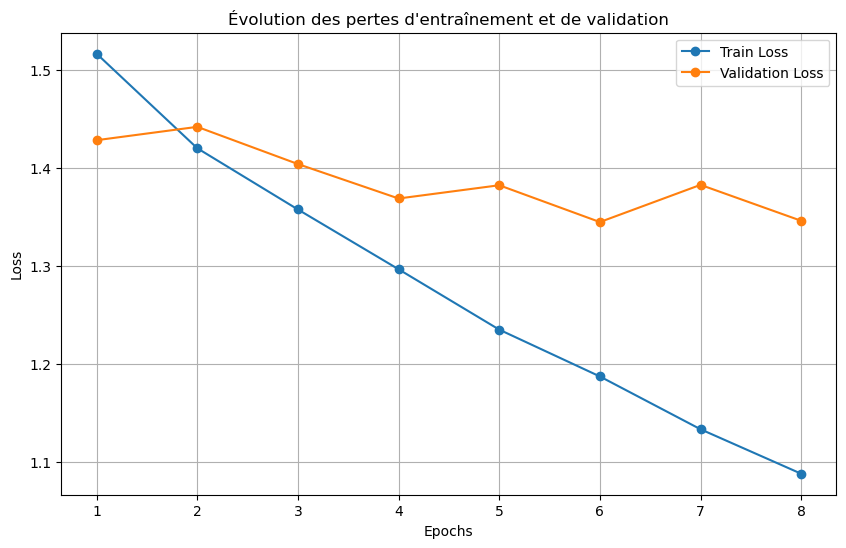

In [17]:
#  Chargement des pertes
df_loss_2b = pd.read_csv("./RESNET50/training_loss_model2b_20250327_014445.txt")

#  Tracer l'évolution des pertes
plt.figure(figsize=(10, 6))
plt.plot(df_loss_2b["Epoch"], df_loss_2b["Train Loss"], label="Train Loss", marker="o")
plt.plot(df_loss_2b["Epoch"], df_loss_2b["Val Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution des pertes d'entraînement et de validation")
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

Évaluation sur Train: 100%|██████████| 2123/2123 [25:26<00:00,  1.39it/s]



 Classification Report (Train):
                             precision    recall  f1-score   support

         Accessoire Console       0.54      0.47      0.50      1345
                     Animal       0.75      0.31      0.44       659
       Autour de la piscine       0.85      0.87      0.86      8167
             Autour du bébé       0.49      0.56      0.52      2593
                  Bricolage       0.58      0.41      0.48      1997
   Bureautique et papeterie       0.81      0.63      0.71      3991
           Carte Collection       0.92      0.93      0.92      3162
                    Chambre       0.70      0.86      0.77      3442
             Console de jeu       0.74      0.79      0.77       666
                    Cuisine       0.47      0.86      0.61       642
      Décoration intérieure       0.54      0.55      0.55      3994
                   Figurine       0.72      0.62      0.66      2137
                     Jeu PC       0.81      0.74      0.78       698


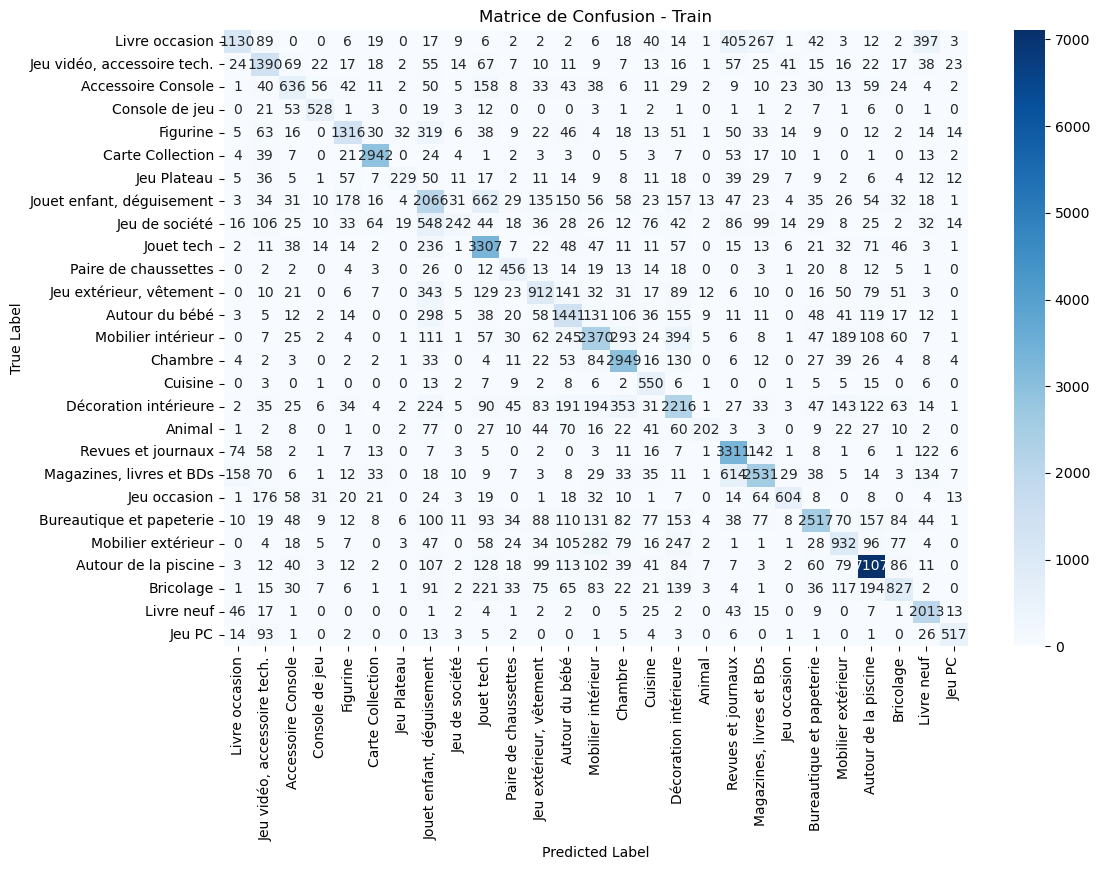

Évaluation sur Validation: 100%|██████████| 266/266 [02:41<00:00,  1.65it/s]



 Classification Report (Validation):
                             precision    recall  f1-score   support

         Accessoire Console       0.33      0.29      0.31       168
                     Animal       0.47      0.11      0.18        82
       Autour de la piscine       0.84      0.83      0.84      1021
             Autour du bébé       0.40      0.48      0.44       324
                  Bricolage       0.47      0.36      0.41       250
   Bureautique et papeterie       0.71      0.62      0.66       499
           Carte Collection       0.86      0.90      0.88       396
                    Chambre       0.67      0.78      0.72       431
             Console de jeu       0.56      0.76      0.64        83
                    Cuisine       0.40      0.78      0.53        81
      Décoration intérieure       0.46      0.47      0.46       499
                   Figurine       0.72      0.50      0.59       267
                     Jeu PC       0.77      0.78      0.78      

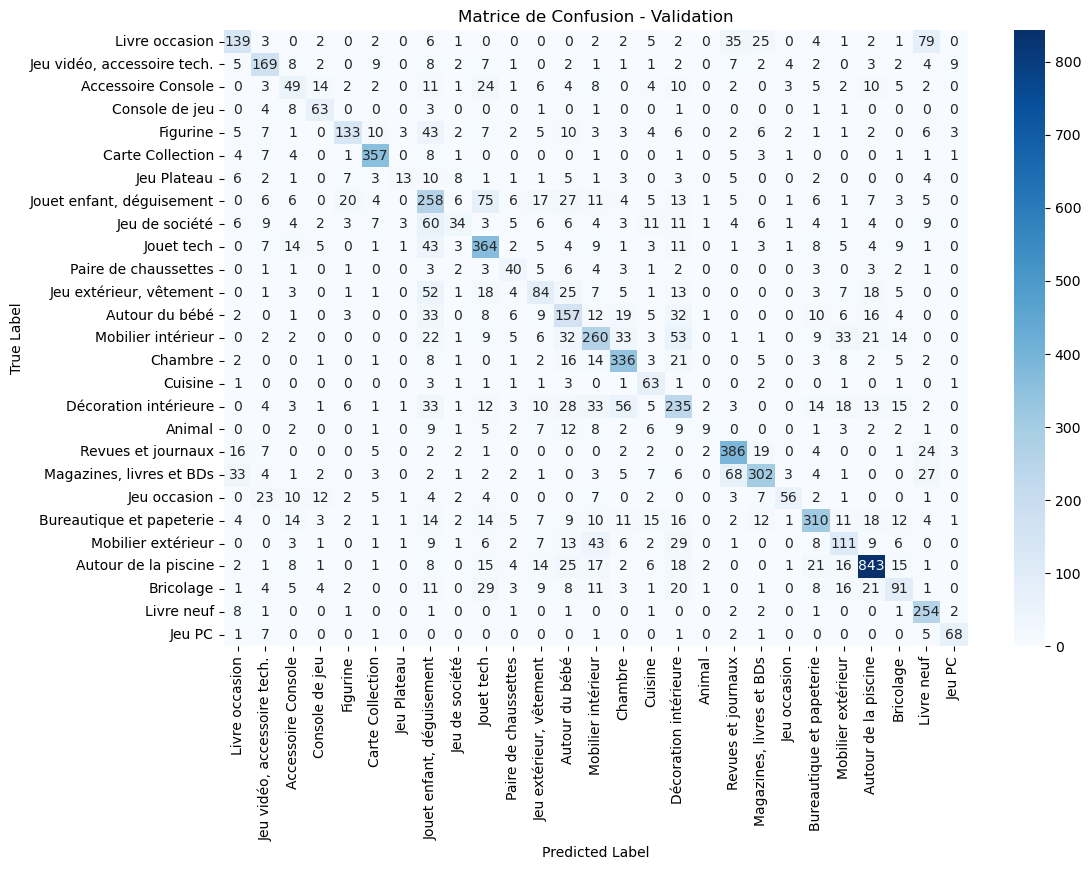

Évaluation sur Test: 100%|██████████| 266/266 [02:42<00:00,  1.63it/s]



 Classification Report (Test):
                             precision    recall  f1-score   support

         Accessoire Console       0.39      0.36      0.37       168
                     Animal       0.68      0.16      0.25        83
       Autour de la piscine       0.82      0.81      0.82      1021
             Autour du bébé       0.36      0.43      0.39       324
                  Bricolage       0.42      0.33      0.37       249
   Bureautique et papeterie       0.72      0.63      0.67       499
           Carte Collection       0.88      0.93      0.91       395
                    Chambre       0.66      0.84      0.74       430
             Console de jeu       0.54      0.75      0.63        83
                    Cuisine       0.39      0.75      0.52        80
      Décoration intérieure       0.46      0.48      0.47       500
                   Figurine       0.72      0.49      0.59       267
                     Jeu PC       0.76      0.80      0.78        87
 

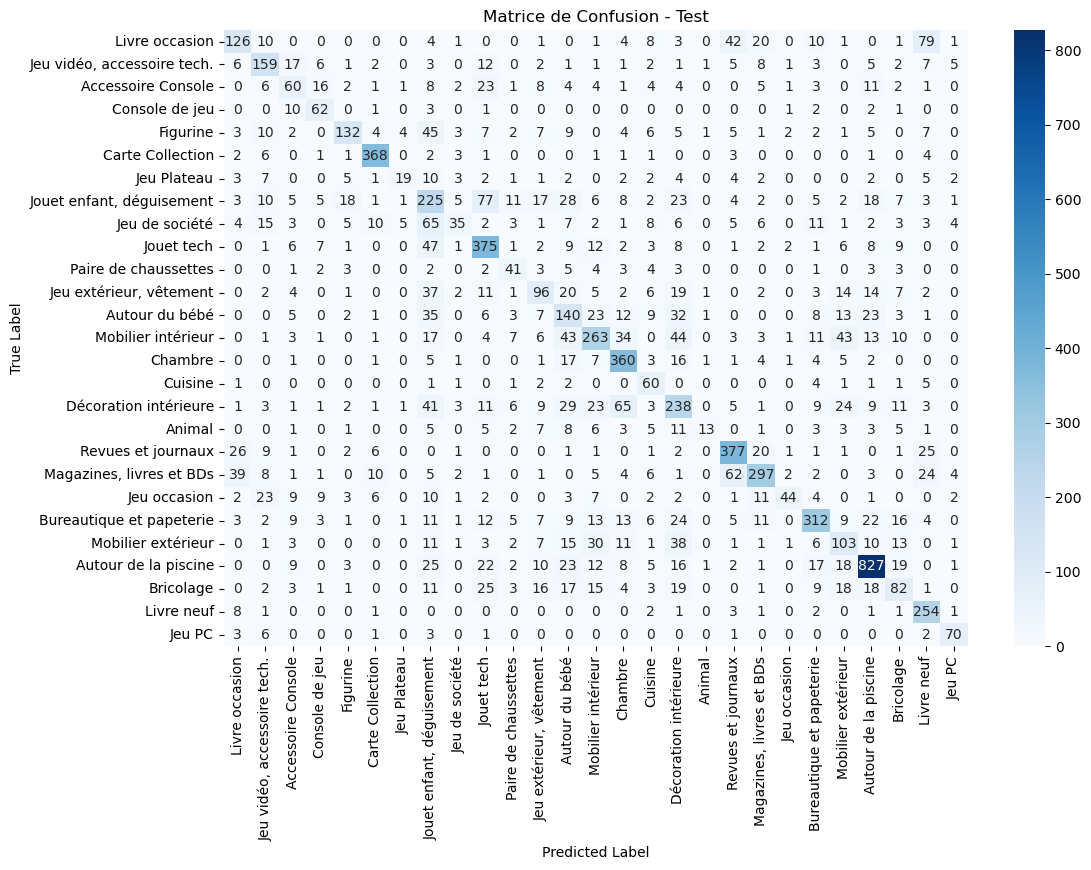

In [21]:
# Chargement du modèle entraîné
model_path = "./RESNET50/resnet50_model2b_20250327_014445.pth" 
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Définition de la fonction d'évaluation
def evaluate_model(dataloader, dataset_name):
    y_true = []
    y_pred = []

    # Évaluation du modèle
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Évaluation sur {dataset_name}"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Conversion des index en noms de catégories
    true_labels = [catid_to_label[index_to_catid[label]] for label in y_true]
    pred_labels = [catid_to_label[index_to_catid[pred]] for pred in y_pred]

    # Rapport de classification
    print(f"\n Classification Report ({dataset_name}):")
    report = classification_report(true_labels, pred_labels)
    print(report)

    # Calcul du F1-score weighted
    f1_weighted = f1_score(true_labels, pred_labels, average="weighted")
    print(f" F1-score weighted ({dataset_name}): {f1_weighted:.4f}")

    # Matrice de confusion
    labels_order = list(catid_to_label.values())
    conf_matrix = confusion_matrix(true_labels, pred_labels, labels=labels_order)

    # Affichage de la heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Matrice de Confusion - {dataset_name}")
    plt.show()

# Évaluation sur train, validation et test
evaluate_model(train_loader_2b, "Train")
evaluate_model(val_loader_2b, "Validation")
evaluate_model(test_loader_2b, "Test")